In [1]:
import numpy as np
import pandas as pd
import warnings

In [2]:
from datetime import datetime

current_time = datetime.now().strftime("%H:%M:%S")
print("Time started =", current_time)

Time started = 16:44:43


In [3]:
data = pd.read_csv("train.csv")

# EDA

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [6]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [7]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [8]:
data = data.fillna("")

## Exploring variables

In [10]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.ticker as mticker

### Duplicates and mislabeled data

In [11]:
data.text.duplicated(keep=False).value_counts()

False    7552
True       61
dtype: int64

In [12]:
data[data.text.duplicated(keep=False)].target.value_counts()

1    121
0     58
Name: target, dtype: int64

In [13]:
all_dups = data[data.duplicated(subset=['text'], keep=False)].text
all_dups.nunique()

69

In [14]:
mislabeled_dups = all_dups[all_dups.apply(lambda x: data[data.text==x].target.nunique()==2)]
data.iloc[mislabeled_dups.index].sort_values(by='text')[:10]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into ...,0
4221,5996,hazardous,,#foodscare #offers2go #NestleIndia slips into ...,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into ...,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1


In [15]:
data_no_mislabeled = data.drop(mislabeled_dups.index)
data_no_duplicated = data.drop_duplicates(subset=['text'], keep=False)

In [16]:
work_data = data_no_mislabeled 

### Helpers

In [17]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = work_data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, work_data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [18]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = work_data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [19]:
work_data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [20]:
mutual_info_score(work_data['keyword'], work_data['target']), mutual_info_score(work_data['keyword'], shuffled_target)

(0.17132360315051776, 0.01667412695998024)

In [21]:
sorted_corr_coefs(work_data, "keyword", "target")[:10], sorted_corr_coefs(work_data, "keyword", "target")[-10:]

([('keyword=derailment', 0.08302992384814313),
  ('keyword=wreckage', 0.08302992384814298),
  ('keyword=debris', 0.08086218013088244),
  ('keyword=outbreak', 0.08040918816372149),
  ('keyword=typhoon', 0.07817379537898307),
  ('keyword=oil%20spill', 0.07817379537898284),
  ('keyword=suicide%20bombing', 0.07229181842864764),
  ('keyword=suicide%20bomber', 0.06980413608593596),
  ('keyword=rescuers', 0.06682449786303161),
  ('keyword=suicide%20bomb', 0.06682449786303152)],
 [('keyword=explode', -0.05032173057874939),
  ('keyword=wrecked', -0.05127748262122846),
  ('keyword=traumatised', -0.05128953808511176),
  ('keyword=screaming', -0.05224239029628636),
  ('keyword=electrocute', -0.05244341052765653),
  ('keyword=body%20bag', -0.05338676579344253),
  ('keyword=blazing', -0.05431426121493636),
  ('keyword=ruin', -0.057009050576103566),
  ('keyword=aftershock', -0.058308609736542324),
  ('keyword=body%20bags', -0.06042093668166045)])

### Variable "location"

In [22]:
work_data.location.value_counts()

                          2503
USA                        104
New York                    71
United States               50
London                      45
                          ... 
Paulton, England             1
SEA Server                   1
todaysbigstock.com           1
buenos aires argentina       1
Lincoln                      1
Name: location, Length: 3329, dtype: int64

In [23]:
mutual_info_score(work_data['location'], work_data['target']), mutual_info_score(work_data['location'], shuffled_target)

(0.31411093454954364, 0.30039038689558417)

In [24]:
sorted_corr_coefs(work_data, "location", "target")[:10], sorted_corr_coefs(work_data, "location", "target")[-10:]

([('location=USA', 0.05127865597035373),
  ('location=Mumbai', 0.04740569396538076),
  ('location=India', 0.046064880856544844),
  ('location=Nigeria', 0.04390256662704054),
  ('location=Washington, DC', 0.030385934048704856),
  ('location=Nairobi-KENYA', 0.026529183512312968),
  ('location=Bend, Oregon', 0.026529183512312888),
  ('location=Calgary', 0.02652918351231286),
  ('location=MAD as Hell', 0.026529183512312843),
  ('location=Sacramento', 0.02652918351231284)],
 [('location=Texas, USA', -0.022317363198970618),
  ('location=Leeds, England', -0.022317363198970635),
  ('location=Wisconsin', -0.02231736319897064),
  ('location=Coventry', -0.022317363198970652),
  ('location=ss', -0.024218473556252923),
  ('location=London, England', -0.024218473556252926),
  ('location=Morioh, Japan', -0.024449065050066745),
  ('location=Pennsylvania, USA', -0.026409757069899925),
  ('location=304', -0.02994981634009949),
  ('location=New York', -0.04013313127058214)])

### Variable "text"

In [25]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(work_data['text'])
vectors.shape

(7558, 21612)

In [27]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], work_data.text[0]

([('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('earthquake', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

#### Hashtags

In [28]:
hashtag_pattern = r'#(\w+)'

hashtags = work_data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=5, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['1', 'abstorm', 'africa', 'animalrescue', 'antioch', 'armageddon',
        'art', 'bb17', 'bbc', 'best', 'bestnaijamade', 'beyhive',
        'breaking', 'business', 'california', 'cnn', 'course', 'dance',
        'directioners', 'disaster', 'dnb', 'drought', 'dubstep',
        'earthquake', 'edm', 'emergency', 'emmerdale', 'fashion',
        'fukushima', 'gbbo', 'god', 'hailstorm', 'handbag', 'hiring',
        'hiroshima', 'hot', 'ices', 'india', 'iphone', 'irandeal', 'isis',
        'islam', 'japan', 'job', 'jobs', 'kerricktrial', 'kindle',
        'landslide', 'lgbt', 'libya', 'lies', 'mh370', 'military',
        'mtvhottest', 'mumbai', 'myanmar', 'news', 'newyork', 'nowplaying',
        'np', 'nuclear', 'nursing', 'okwx', 'pakistan', 'pantherattack',
        'phoenix', 'photography', 'prebreak', 'preparedness', 'quran',
        'refugees', 'rohingya', 'rt', 'science', 'seattle', 'sismo',
        'sittwe', 'socialnews', 'somalia', 'soundcloud', 'summerfate',
        'tbt', 't

In [29]:
work_data['hashtags'] = hashtags
work_data

,id,keyword,location,text,target,hashtags
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[]
7611,10872,,,Police investigating after an e-bike collided ...,1,[]


#### URLs

In [30]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [31]:
work_data.text[work_data.text.str.findall(url_pattern).apply(len) > 0].shape

(3965,)

Let's observe correlation of different words with target

In [32]:
columns = np.transpose(vectors.todense().A)

corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, work_data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [33]:
named_list[0:10], named_list[-10:]

([('http', 0.21452627610618558),
  ('co', 0.197184075655397),
  ('in', 0.1671580742879547),
  ('california', 0.1310149967949288),
  ('suicide', 0.12455801698077225),
  ('hiroshima', 0.1210916441867206),
  ('killed', 0.11979142932138698),
  ('mh370', 0.11002041366833958),
  ('wildfire', 0.10672655178990342),
  ('northern', 0.10654069392403501)],
 [('if', -0.06876362740044957),
  ('can', -0.07148314636945576),
  ('it', -0.07295391366915743),
  ('full', -0.07322194151418458),
  ('so', -0.07565381719162129),
  ('your', -0.0779455118166616),
  ('body', -0.08382709834151313),
  ('me', -0.08893371278948647),
  ('my', -0.12906704047732429),
  ('you', -0.15455528784196004)])

In [34]:
urls = work_data.text.str.lower().str.findall(url_pattern)
url_c_vect = CountVectorizer(min_df=3, analyzer=lambda x: x)
url_vectors = url_c_vect.fit_transform(urls)
url_c_vect.get_feature_names_out(), len(url_c_vect.get_feature_names_out())

(array(['http://t.co/0wratka2jl', 'http://t.co/9nwajli9cr',
        'http://t.co/bbdpnj8xsx', 'http://t.co/cedcugeuws',
        'http://t.co/cybksxhf7d', 'http://t.co/encmhz6y34',
        'http://t.co/ksawlyux02', 'http://t.co/lvlh3w3awo',
        'http://t.co/nnmqlz91o9', 'http://t.co/o91f3cyy0r',
        'http://t.co/q2eblokeve', 'http://t.co/qew4c5m1xd',
        'http://t.co/thoyhrhkfj', 'http://t.co/v3azwoamzk',
        'http://t.co/viwxy1xdyk', 'http://t.co/vvplfqv58p',
        'http://t.co/wvj39a3bgm', 'http://t.co/zujwuiomb3',
        'https://t.co/dehmym5lpk', 'https://t.co/e8dl1lncvu',
        'https://t.co/moll5vd8yd'], dtype=object),
 21)

In [35]:
work_data['urls'] = urls

In [36]:
work_data

,id,keyword,location,text,target,hashtags,urls
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[],[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[],[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",[]
...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[],[http://t.co/stfmbbzfb5]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[],[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[],[http://t.co/zdtoyd8ebj]
7611,10872,,,Police investigating after an e-bike collided ...,1,[],[]


#### Emoji

In [37]:
import emoji

In [38]:
print(work_data.text.apply(emoji.distinct_emoji_list)[work_data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


### Target value counts

0    4313
1    3245
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7f39834a8e20>,
 [Text(-0.24216139986342314, 1.0730134465216117, '0'),
  Text(0.242161399863423, -1.0730134465216117, '1')])

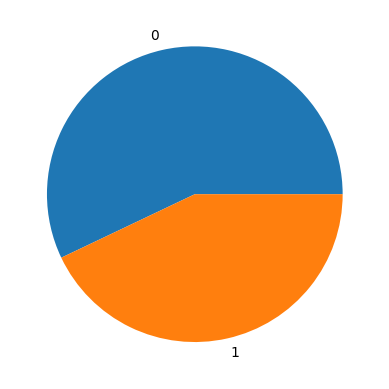

In [39]:
print(work_data.target.value_counts())
plt.pie(work_data.target.value_counts(), labels = (0,1))

# Training Models

## Plan

We are going to try various data preparation and transformation steps and try them on several different classification models.
The whole pipeline will be as follows:

1. Data Preparation
    1. CountVectorizer applied to the `text` column as central part of preparation
    1. Additional steps:
        1. Cleanup URLs from text
        1. `keyword` column vectorization
        1. `location` column vectorization
        1. The newly created `hashtags` column vectorization
        1. Using stopwords
        1. Stemming
        1. Lemmatization
        1. ngrams
    1. By end of this stage we'll get a sparce matrix of vectors, that could be fed into different models. Testing different combinations we'll find the best steps for each model
1. Data transformation and dimensionality reduction
    1. The following techniques will be performed on the data from the previous stage:
        1. Polynomialization
        1. SelectKBest
        1. TruncatedSVD
    1. GridSearchCV will be used to find the most winning sequence
1. Final Models Parameters Tuning
    1. Each model with it's optimal data pipeline will be run through hyperparameter tuning
1. Testing with test data

### Data Preparation Helpers

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [41]:
import nltk

In [42]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [43]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

In [44]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def lemma_preprocessor_verb(text):
    words=[lemmatizer.lemmatize(w, 'v') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adj(text):
    words=[lemmatizer.lemmatize(w, 'a') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adverb(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_noun(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

In [45]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

In [46]:
df_full_train, df_test = train_test_split(work_data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6046, 7), (1512, 7))

In [47]:
small_train, small_test = train_test_split(work_data, test_size=0.9, random_state=42)
small_train.shape, small_test.shape

X_full_train = small_train.drop('target', axis=1)
y_full_train = small_train.target

In [48]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target

X_test = df_test.drop('target', axis=1)
y_test = df_test.target

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

In [49]:
%load_ext autoreload
%autoreload 2

In [50]:
from preprocess_util import prepare_train_data, prepare_test_vectors, default_preprocess_settings, prepare_cross_val_vectors, my_cross_val_score

### Steps combinations

In [51]:
all_preparation_params = {
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},   
    'URLs': {'urls': True},
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}, 
    'Keyword + Location': {'kw': True, 'loc': True},
    'Keyword + Hashtags': {'kw': True, 'hashtags': True},
    'Keyword + location + Hashtags': {'kw': True, 'hashtags': True, 'loc': True},
    'Keyword + Location + Stemming': {'kw': True, 
                                      'loc': True,
                                      'preprocessor': stem_preprocessor},
    'Keyword + Location + Hashtags + Stemming': {'kw': True,
                                                 'hashtags': True, 
                                                 'loc': True,
                                                 'preprocessor': stem_preprocessor}
}

### List of models

In [52]:
scale_pos_weight = y_full_train.value_counts()[0] / y_full_train.value_counts()[1]

In [53]:
model_nb = ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=500, random_state=42, class_weight="balanced")
model_tree = DecisionTreeClassifier(max_depth=7, class_weight="balanced")
model_forest = RandomForestClassifier(n_estimators=50,
                            max_depth=7,
                            min_samples_leaf=2,
                            random_state=42, 
                            class_weight="balanced",
                            n_jobs=-1)
model_xgb = XGBClassifier(learning_rate=0.2,
                          n_estimators=10, 
                          max_depth=7, 
                          min_child_weight=1, 
                          objective="binary:logistic", 
                          scale_pos_weight=scale_pos_weight, 
                          seed=42,
                          n_jobs=8)

In [54]:
class Models:
    nb_key = 'Naive Bayes'
    rc_key = 'Ridge Classifier'
    lr_key = 'Logistic Regression'
    tree_key = 'Tree'
    forest_key = 'Forest'
    xgb_key = 'XGBoost'

In [55]:
def make_model(key):
    match key:     
        case Models.nb_key:
            return ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
        case Models.rc_key:
            return RidgeClassifier(class_weight="balanced")
        case Models.lr_key:
            return LogisticRegression(class_weight="balanced", max_iter=500)
        case Models.tree_key:
            return DecisionTreeClassifier(class_weight="balanced")
        case Models.forest_key:
            return RandomForestClassifier(class_weight="balanced", n_jobs=-1)
        case Models.xgb_key:
            return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=8)

In [56]:
%%time
all_models_keys = [ 
        Models.nb_key, 
        Models.rc_key, 
        Models.lr_key, 
        Models.tree_key, 
        Models.forest_key, 
        Models.xgb_key
    ]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.68 µs


In [57]:
from preprocess_util import compare_models

## Data Preparation

In [58]:
from preprocess_util import plot_score_diffs

### Steps evaluation

In [59]:
def evaluate_models(models, best_settings=None, feature_key=None):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, model in models.items():
        settings = best_settings[model_key] if best_settings else default_preprocess_settings
        
        vectors = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)
        score = my_cross_val_score(model, vectors['splits']).mean()

        full_train_data = prepare_train_data(X_full_train, y_full_train, settings=settings)
        test_vectors = prepare_test_vectors(X_test, full_train_data)

        model.fit(full_train_data['vectors'], y_full_train)
        test_score = f1_score(model.predict(test_vectors), y_test)

        record_dict[model_key] = score
        test_record_dict[model_key] = test_score    
    scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def kw_to_dict(series):
    return [{'keyword': item[1]} for item in series.items()]

def loc_to_dict(series):
    return [{'location': item[1]} for item in series.items()]

def make_kw_pipeline():
    return Pipeline(steps=[('kw_to_dict', FunctionTransformer(kw_to_dict)),
                              ('d_vect', DictVectorizer())])
def make_loc_pipeline(): 
    return Pipeline(steps=[('kw_to_dict', FunctionTransformer(loc_to_dict)),
                              ('d_vect', DictVectorizer())])


# def make_text_hashtags_vectorizer_transformer():
#     return ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
#                                 ('hashtags_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: x), 'hashtags')])

def make_poly2_k_best_pipeline():
    return Pipeline(steps=[('poly2', PolynomialFeatures(2)),
                                        ('k_best', SelectKBest(chi2))])


In [61]:
def make_vectorizer(
        min_df=5, 
        kw=False, 
        loc=False, 
        hashtags=False,
        urls=False,
        stopwords=None,
        preprocessor=None,
        ngram_range=(1, 1)):
    columns = [('text_c_vect', CountVectorizer(min_df=5, stop_words=stopwords, preprocessor=preprocessor, ngram_range=ngram_range), 'text')]
    if kw:
        columns.append(('kw_dict_vect', make_kw_pipeline(), 'keyword'))
    if loc:
        columns.append(('loc_dict_vect', make_loc_pipeline(), 'location'))
    if hashtags:
        columns.append(('hashtags_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: x), 'hashtags'))
    if urls:
        columns.append(('urls_c_vect', CountVectorizer(min_df=3, analyzer=lambda x: x), 'urls'))        
    
    return ColumnTransformer(columns)
    

def make_preparation_pipeline(
        url_cleaner=None,
        min_df=5, 
        kw=False, 
        loc=False, 
        hashtags=False,
        urls=False,
        stopwords=None,
        preprocessor=None,
        ngram_range=(1, 1),
    ):
    
    vectorizer=make_vectorizer(kw=kw, 
        loc=loc, 
        hashtags=hashtags,
        stopwords=stopwords,
        preprocessor=preprocessor,
        ngram_range=ngram_range)
    
    steps = [('url_cleaner', url_cleaner)]    
    steps.append(('vectorizer', vectorizer))
    
    return Pipeline(steps=steps)

In [62]:
from sklearn.model_selection import cross_val_score

def evaluate_pipelines(pipelines, feature_key=None):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, pipeline in pipelines.items():
        steps = pipeline.steps.copy()
        if not any(step for step in steps if step[0] == 'classifier'):
            steps.append(('classifier', make_model(model_key)))
        clf_pipeline = Pipeline(steps)
        
        score = cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

        clf_pipeline.fit(X_full_train, y_full_train)
        test_score = f1_score(y_test, clf_pipeline.predict(X_test))
        
        record_dict[model_key] = score
        test_record_dict[model_key] = test_score    
    
    scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [63]:
default_pipelines = {
    key: make_preparation_pipeline() for key in all_models_keys
}

In [64]:
default_scores_df = evaluate_pipelines(default_pipelines, feature_key='Default')

In [65]:
default_scores_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.742268,0.715908,0.736405,0.658454,0.700979,0.735714
Default (test),0.764753,0.746667,0.766823,0.668243,0.736099,0.758105


In [66]:
all_preparation_pipelines = {
    key: make_preparation_pipeline(**params) for key, params in all_preparation_params.items()
}

In [67]:
def xval_pipe_with_clf(pipeline, clf):
    steps = pipeline.steps.copy()
    steps.append(('classifier', clf))
    clf_pipeline = Pipeline(steps)

    return cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

In [68]:
def xval_pipes_and_models(pipelines, models_keys):
    df = pd.DataFrame()

    for key, pipeline in pipelines.items():
        record_dict = {model_key: xval_pipe_with_clf(pipeline, make_model(model_key)) for model_key in models_keys}
        record_dict['Features'] = key
        df = pd.concat([df, pd.DataFrame([record_dict])])

    df.set_index('Features', inplace=True)
    
    return df

In [69]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_preparation_scores = xval_pipes_and_models(all_preparation_pipelines, all_models_keys)

CPU times: user 9min 41s, sys: 6.9 s, total: 9min 48s
Wall time: 7min 18s


In [70]:
pd.concat([all_preparation_scores, default_scores_df])

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Url Cleaner,0.743285,0.712665,0.733471,0.652771,0.715047,0.723079
Stemming,0.739390,0.717406,0.740497,0.672545,0.710360,0.736713
Lemmatization,0.729294,0.713562,0.732034,0.646971,0.681621,0.714184
Keyword,0.751171,0.718598,0.737529,0.669089,0.716230,0.735227
Location,0.741103,0.709209,0.737408,0.667919,0.702583,0.736035
Hashtags,0.742291,0.713631,0.735686,0.649346,0.700626,0.736537
URLs,0.742268,0.715908,0.736405,0.661074,0.704029,0.735714
Stopwords,0.735092,0.719348,0.739311,0.683354,0.714173,0.731425
1-2 words ngrams,0.725715,0.700343,0.732297,0.656676,0.692436,0.734845


In [71]:
default_scores_df.loc[['Default (x_val)']]

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.742268,0.715908,0.736405,0.658454,0.700979,0.735714


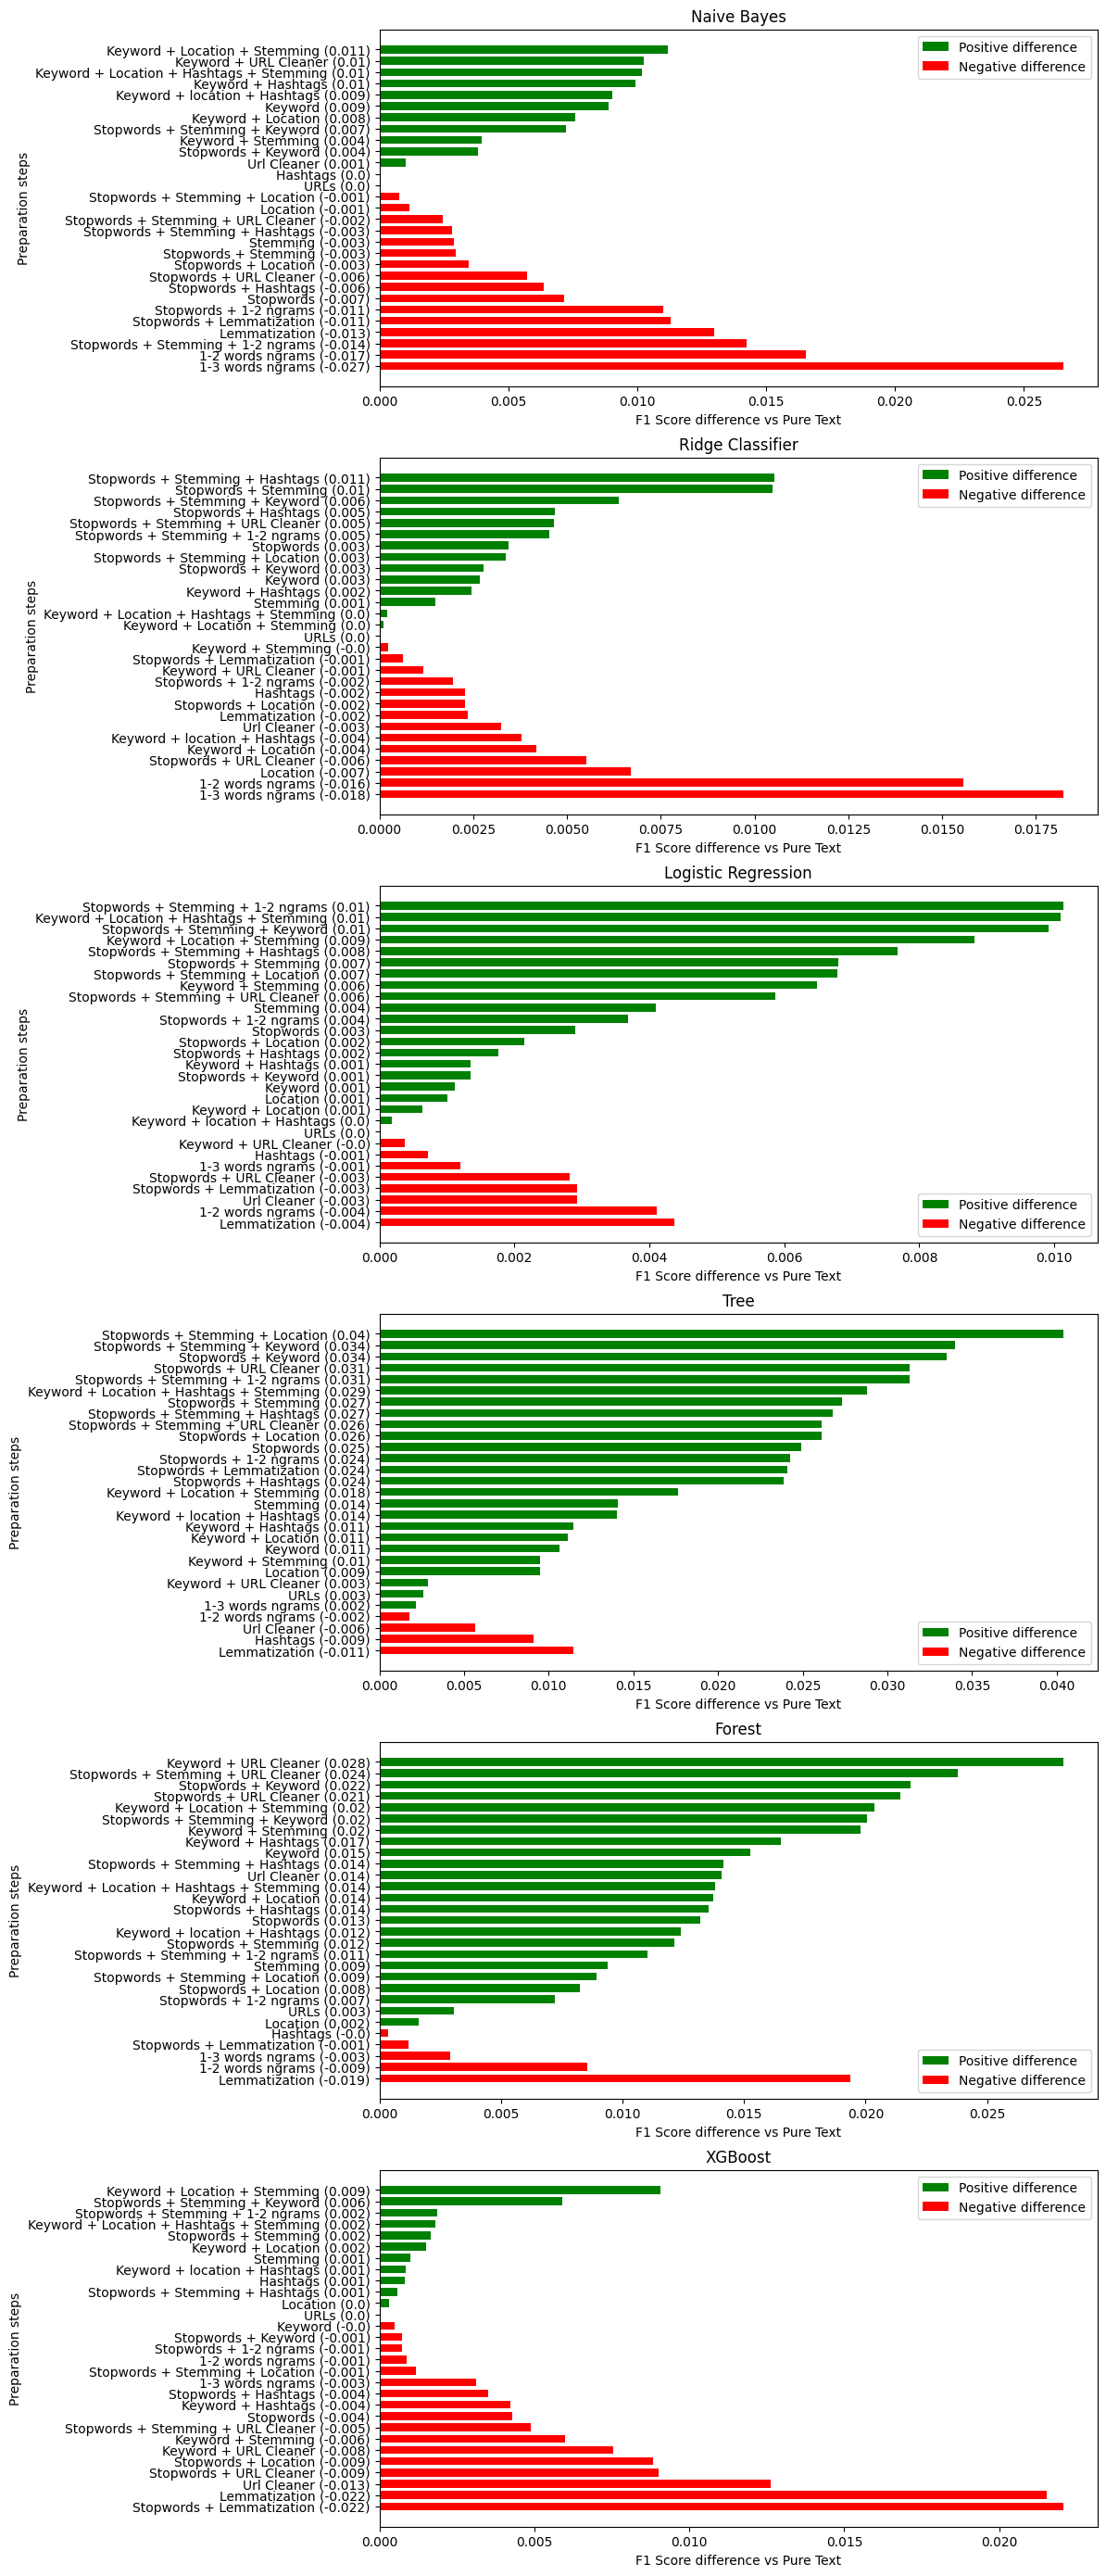

In [72]:
preparation_diffs = all_preparation_scores - default_scores_df.loc['Default (x_val)']
plot_score_diffs(preparation_diffs)

In [73]:
best_preparation_params = preparation_diffs.idxmax()
best_preparation_params

Naive Bayes                Keyword + Location + Stemming
Ridge Classifier         Stopwords + Stemming + Hashtags
Logistic Regression    Stopwords + Stemming + 1-2 ngrams
Tree                     Stopwords + Stemming + Location
Forest                             Keyword + URL Cleaner
XGBoost                    Keyword + Location + Stemming
dtype: object

In [74]:
best_preparation_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

One of the most interesting learnings from this data is that different steps that have positive effect on the score when applied separately, have negative effect when combined together. E.g. `keyword` and `stemming` in XGBoost

### Best preparation steps per model

In [75]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preparation_scores_df = evaluate_pipelines(best_preparation_pipelines, feature_key='Data preparation')

CPU times: user 33 s, sys: 290 ms, total: 33.3 s
Wall time: 21.1 s


In [76]:
pd.concat((default_scores_df, preparation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.742268,0.715908,0.736405,0.658454,0.700979,0.735714
Default (test),0.764753,0.746667,0.766823,0.668243,0.736099,0.758105
Data preparation (x_val),0.753448,0.726446,0.746534,0.689845,0.730756,0.744794
Data preparation (test),0.757962,0.729002,0.749407,0.703618,0.750000,0.750416


## Data Transformation. Polynomialization and Dimensionality Reduction

In [77]:
from preprocess_util import k_range_scores, svd_n_range_scores, plot_k_range_results, plot_svd__range_results

In [78]:
def pipe_with_transformations(key):
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]]) 
    classifier = make_model(key)
    
    steps = pipeline.steps.copy()
    steps.append(('poly2_k_best', make_poly2_k_best_pipeline()))
    steps.append(('svd', TruncatedSVD()))
    steps.append(('classifier', classifier))
    return Pipeline(steps)

In [79]:
def min_n_features(key):
    X = X_full_train
    y = y_full_train
    pipeline = best_preparation_pipelines[key]
    pipeline.fit(X, y)
    min_n = None
    for split in cv.split(X, y):
        n = pipeline.fit_transform(X.iloc[split[0]], y.iloc[split[0]]).shape[1]
        min_n = n if min_n is None else min(n, min_n)
            
    return min_n

In [80]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print ({key: min_n_features(key) for key in all_models_keys})

{'Naive Bayes': 4171, 'Ridge Classifier': 1744, 'Logistic Regression': 2269, 'Tree': 3841, 'Forest': 2106, 'XGBoost': 4171}


In [81]:
# these ranges where obtained after couple iterations
k_ranges_dict = {
    Models.nb_key: np.concatenate(
                            (np.linspace(100, 4100, 9, dtype=int),
                            np.linspace(5000, 15000, 3, dtype=int))),
    Models.rc_key:  np.concatenate(
                            (np.linspace(100, 1700, 5, dtype=int),
                             np.linspace(2500, 4500, 3, dtype=int))),
    Models.lr_key:  np.concatenate(
                            (np.linspace(100, 2100, 6, dtype=int),
                             np.linspace(2500, 4500, 3, dtype=int))),
    Models.tree_key: np.concatenate(
                            (np.linspace(100, 4100, 9, dtype=int),
                            np.linspace(5000, 8000, 4, dtype=int))),
    Models.forest_key: np.concatenate(
                            (np.linspace(100, 2100, 6, dtype=int),
                             np.linspace(2500, 4500, 3, dtype=int))),
    Models.xgb_key: np.concatenate(
                            (np.linspace(100, 4100, 9, dtype=int),
                            np.linspace(5000, 8000, 4, dtype=int))),
}

In [ ]:
%%time
k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        k_ranges_dict[k])  
    for k in all_models_keys
}

k_range_results = k_range_scores(k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

In [ ]:
plot_k_range_results(k_range_results)

In [164]:
%%time

best_k_dict = {
    Models.rc_key: (900, 3500),
    Models.lr_key: (1100, 4000),
    Models.tree_key: (3800, 5800),
    Models.forest_key: (2000, 6000),
    Models.xgb_key: (1600, 4000)
}

svd_params_dict = {
    key: {
        'pipe': pipe_with_transformations(key),
        'n_range': np.linspace(100, 1000, 10, dtype=int),
        'no_poly_k': best_k[0],
        'poly_2_k': best_k[1],
        'cv': cv,
        'X': X_full_train,
        'y': y_full_train
    } for key, best_k in best_k_dict.items()
}
    
svd_n_range_results = svd_n_range_scores(svd_params_dict)

Doing another pipe
Doing another pipe
Doing another pipe
Doing another pipe
Doing another pipe
CPU times: user 9h 42min 57s, sys: 1h 38min 23s, total: 11h 21min 21s
Wall time: 6h 1min


#HERE

In [153]:
all_preparation_params[best_preparation_params[Models.lr_key]]

{'kw': True, 'hashtags': True}

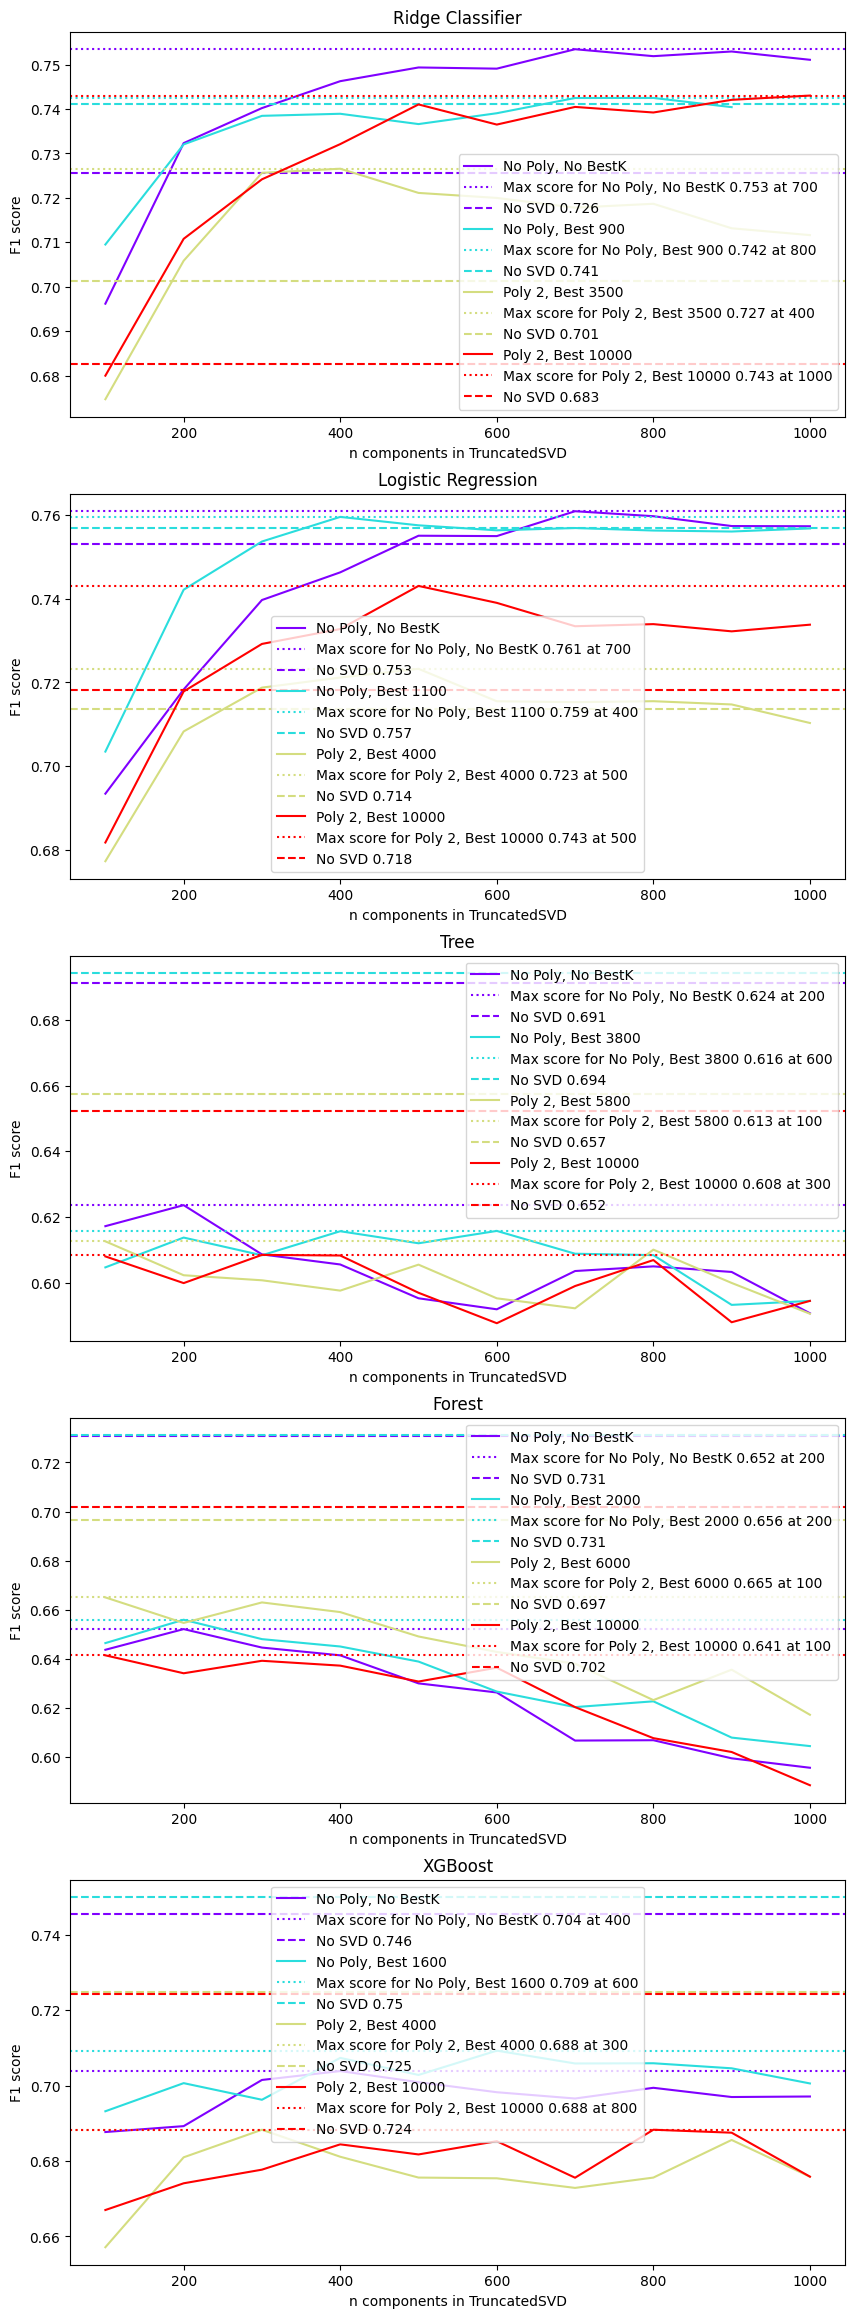

In [165]:
plot_svd__range_results(svd_n_range_results)

### Best transformation scores

In [180]:
best_transformation_params = {
    Models.nb_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 1750, 'svd': 'passthrough'},
    Models.rc_key: {'poly2_k_best': 'passthrough', 'svd__n_components': 700},
    Models.lr_key: {'poly2_k_best': 'passthrough', 'svd__n_components': 700},
    Models.tree_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.forest_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.xgb_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 1600, 'svd': 'passthrough'}
}

def make_best_transformation_pipeline(key):
    pipeline = pipe_with_transformations(key)

    pipeline.set_params(**(best_transformation_params[key]))
    return pipeline    

In [184]:
best_transformation_pipelines = {
    key: make_best_transformation_pipeline(key) for key in best_transformation_params.keys()
}

In [185]:
transformation_scores_df = evaluate_pipelines(best_transformation_pipelines, feature_key='Data transformation')

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

In [186]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.745691,0.722527,0.750751,0.651173,0.704528,0.732792
Default (test),0.742496,0.732157,0.758353,0.655359,0.726650,0.733227
Data preparation (x_val),0.754771,0.725599,0.752912,0.695181,0.727638,0.745573
Data preparation (test),0.748019,0.720623,0.758674,0.702209,0.726821,0.748800
Data transformation (x_val),0.756757,0.750984,0.758621,0.690754,0.732808,0.750037
Data transformation (test),0.741608,0.741259,0.760153,0.696525,0.736053,0.734824


## Final Models Parameters Tuning

In [373]:
def grid_search_fast(pipe, param_grid, X, y):
    fast_cv = [next(cv.split(X, y))]
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=fast_cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [444]:
def grid_search(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [445]:
def plot_grid_results(results, x_var, legend_var=None, log=False):
    if legend_var is None:
        legend_values=['dummy']
    else:
        legend_values=results.param_grid[legend_var]
    for l_val in legend_values:
        scores = results.cv_results_['mean_test_score']
        x_values =  results.cv_results_[f'param_{x_var}'].data
        if legend_var:
            mask = [item[legend_var] == l_val for item in results.cv_results_['params']]
            scores = scores[mask]
            x_values = x_values[mask]
        if log:
            axes = plt.subplot()
            axes.set_xscale('log')
        plt.plot(x_values, scores, label=f'{legend_var} = {l_val}' if legend_var else '')
    plt.xlabel(x_var)
    plt.ylabel(results.scoring)
    if legend_var is not None:
        plt.legend()

In [ ]:
def grid_and_plot(
    pipe,
    params_grid,
    range_var,
    legend_var=None,
    log=False):
    
    results = grid_search(pipe, params_grid, X_full_train, y_full_train)
    plot_grid_results(results, range_var, legend_var=legend_var, log=log)

In [447]:
best_fine_tuning_params = {}

### Naive Bayes

Tuned Hyperparameters : {'classifier__alpha': 0.1}
F1 score : 0.7578412180351317
________________________
CPU times: user 2.22 s, sys: 9.28 ms, total: 2.23 s
Wall time: 2.23 s


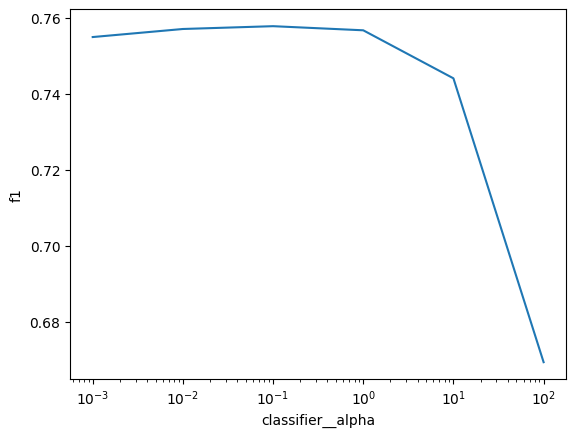

In [446]:
%%time

nb_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6)
}

nb_tuning_results = grid_search(make_best_transformation_pipeline(Models.nb_key), nb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(nb_tuning_results, 'classifier__alpha', log=True)

In [448]:
best_fine_tuning_params[Models.nb_key] = {
    'classifier__alpha': 0.1
}

### Ridge Classifier

In [192]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'saga', 'sag'],
}

rc_tuning_results = grid_search(make_best_transformation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__alpha': 10.0, 'classifier__solver': 'saga'}
F1 score : 0.7575887525801738
________________________
CPU times: user 9min 16s, sys: 9min 57s, total: 19min 14s
Wall time: 3min 29s


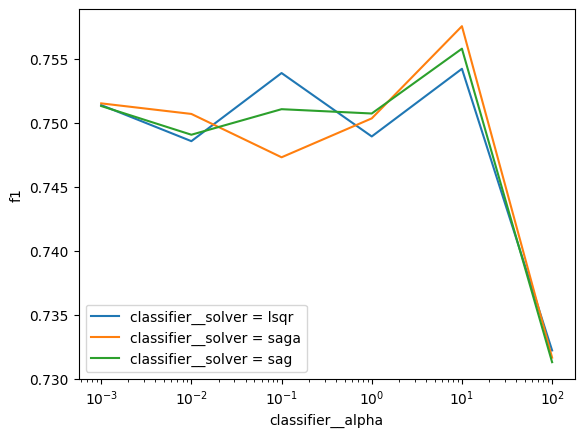

In [247]:
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver', log=True)

Tuned Hyperparameters : {'classifier__alpha': 0.13999999999999999, 'classifier__solver': 'lsqr'}
F1 score : 0.7533352713170035
________________________
CPU times: user 6min 24s, sys: 7min 59s, total: 14min 23s
Wall time: 1min 59s


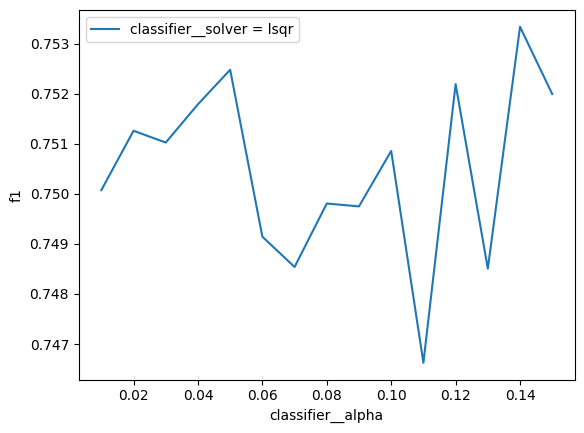

In [257]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.linspace(0.01, 0.15, 15),
    'classifier__solver': ['lsqr']
}

rc_tuning_results = grid_search(make_best_transformation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver')

Tuned Hyperparameters : {'classifier__alpha': 13.0, 'classifier__solver': 'saga'}
F1 score : 0.7591392162659126
________________________
CPU times: user 7min 3s, sys: 7min 28s, total: 14min 32s
Wall time: 2min 55s


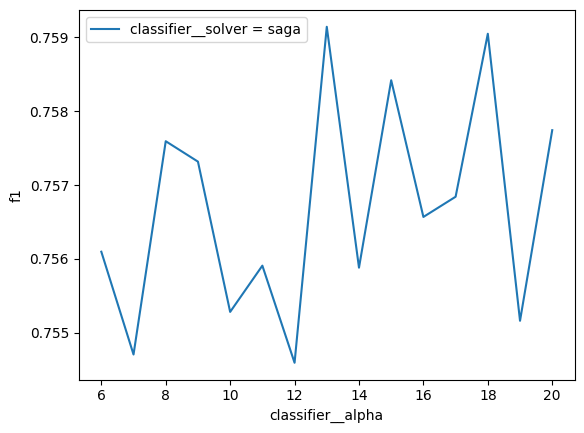

In [256]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.linspace(6, 20, 15),
    'classifier__solver': ['saga']
}

rc_tuning_results = grid_search(make_best_transformation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver')

In [449]:
best_fine_tuning_params[Models.rc_key] = {
    'classifier__alpha': 13,
    'classifier__solver': 'saga'
}

### Logistic Regression

In [194]:
%%time

lr_tuning_grid = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

lr_tuning_results = grid_search(make_best_transformation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__solver': 'lbfgs'}
F1 score : 0.761894691574133
________________________
CPU times: user 15min 20s, sys: 14min 10s, total: 29min 30s
Wall time: 7min 8s


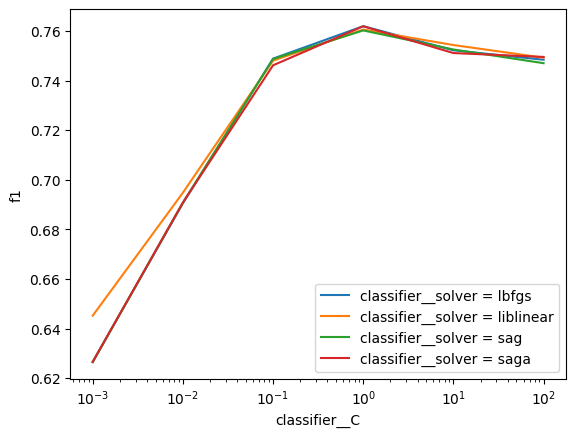

In [249]:
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver', log=True)

Tuned Hyperparameters : {'classifier__C': 0.8999999999999999, 'classifier__solver': 'lbfgs'}
F1 score : 0.7634318299235728
________________________
CPU times: user 6min 27s, sys: 8min 17s, total: 14min 45s
Wall time: 1min 57s


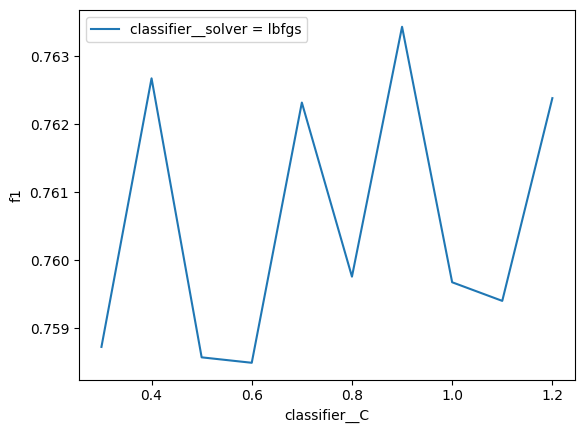

In [259]:
%%time

lr_tuning_grid = {
    'classifier__C': np.linspace(0.3, 1.2, 10),
    'classifier__solver': ['lbfgs']
}

lr_tuning_results = grid_search(make_best_transformation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver')

In [450]:
best_fine_tuning_params[Models.lr_key] = {
    'classifier__C': 0.9,
    'classifier__solver': 'lbfgs'
}

### Decision Tree

In [279]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 3, 5, 10, 20, 50, 100, 120, 130, 140, 150, 170, 200, 300, None]
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140}
F1 score : 0.7029166470533982
________________________
CPU times: user 1min 21s, sys: 16.6 ms, total: 1min 21s
Wall time: 1min 21s


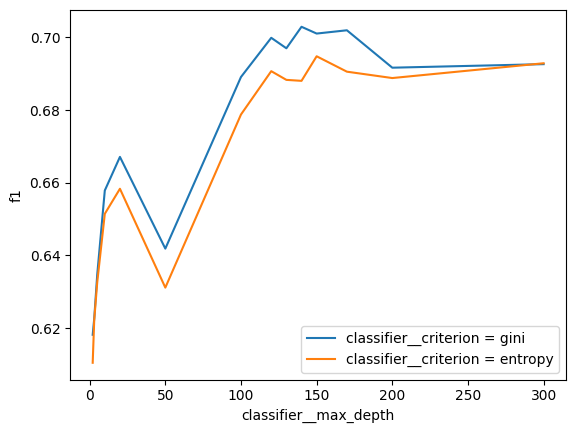

In [280]:
plot_grid_results(tree_tuning_results, 'classifier__max_depth', legend_var='classifier__criterion')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140, 'classifier__min_samples_leaf': 1}
F1 score : 0.7013318606082799
________________________
CPU times: user 4min 32s, sys: 2.09 ms, total: 4min 32s
Wall time: 4min 32s


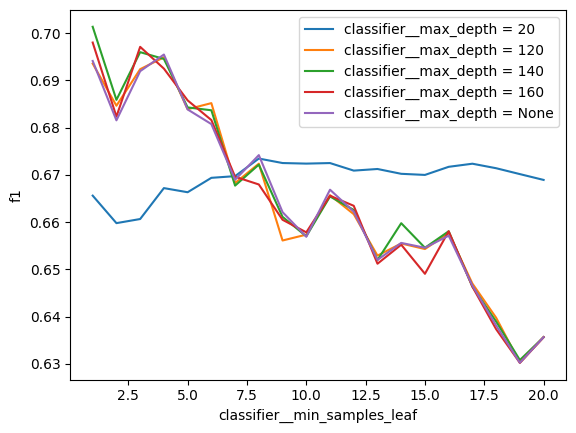

In [314]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [20, 120, 140, 160, None],
    'classifier__min_samples_leaf': np.linspace(1, 20, 20, dtype=int)
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_leaf', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 160, 'classifier__min_samples_split': 500}
F1 score : 0.7139533647519085
________________________
CPU times: user 2min 50s, sys: 14.6 ms, total: 2min 50s
Wall time: 2min 50s


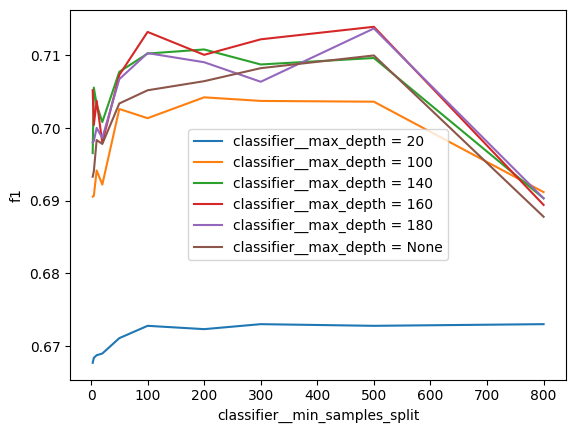

In [286]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [20, 100, 140, 160, 180, None],
    'classifier__min_samples_split': [1, 3, 5, 10, 20, 50, 100, 200, 300, 500, 800]
}

tree_tuning_results = grid_search(make_best_transformation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_split', legend_var='classifier__max_depth')

In [451]:
best_fine_tuning_params[Models.tree_key] = {
    'classifier__criterion': 'gini',
    'classifier__max_depth': 160,
    'classifier__min_samples_split': 100
}

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 250, 'classifier__n_estimators': 170}
F1 score : 0.7365126049454862
________________________
CPU times: user 2min 14s, sys: 22.2 s, total: 2min 36s
Wall time: 5min


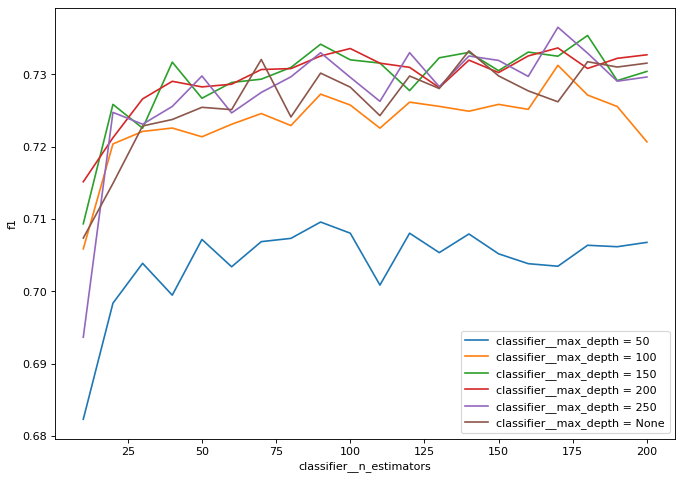

In [408]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [50, 100, 150, 200, 250, None],
    'classifier__n_estimators': np.linspace(10, 200, 20, dtype=int)
}

forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 140}
F1 score : 0.7371885735080447
________________________
CPU times: user 1min 43s, sys: 20.1 s, total: 2min 3s
Wall time: 4min 1s


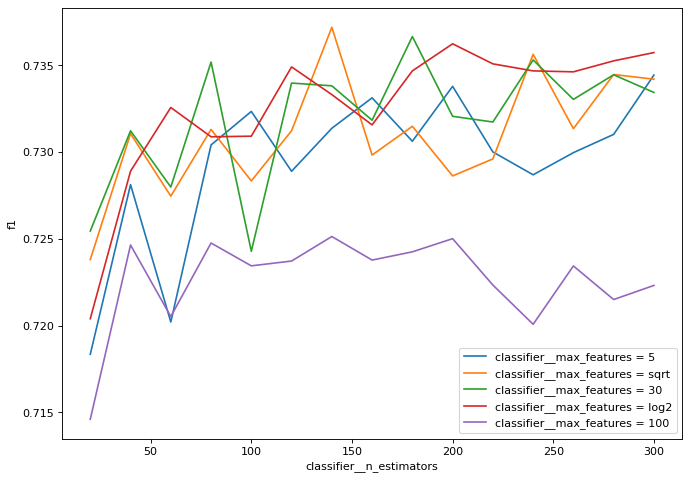

In [413]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': [5, 'sqrt', 30, 'log2', 100],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_features')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 300}
F1 score : 0.7599366846911231
________________________
CPU times: user 1min 42s, sys: 22.9 s, total: 2min 5s
Wall time: 2min 23s


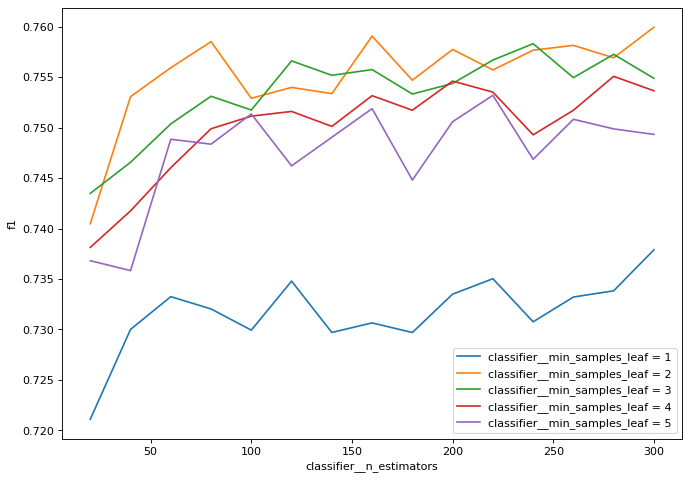

In [415]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_leaf')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 500, 'classifier__n_estimators': 300}
F1 score : 0.7613425319815235
________________________
CPU times: user 55.5 s, sys: 16.3 s, total: 1min 11s
Wall time: 1min 10s


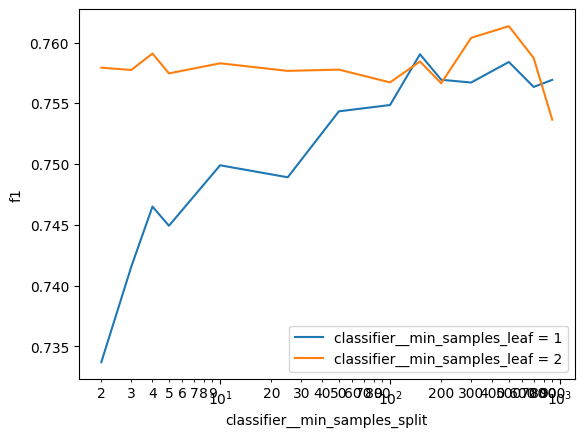

In [430]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2],

    'classifier__min_samples_split': [2, 3, 4, 5, 10, 25, 50, 100, 150, 200, 300, 500, 700, 900],
    'classifier__n_estimators': [300]
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
plot_grid_results(forest_tuning_results, 'classifier__min_samples_split', legend_var='classifier__min_samples_leaf', log=True)

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 240}
F1 score : 0.7608791438235627
________________________
CPU times: user 1min 1s, sys: 15.1 s, total: 1min 16s
Wall time: 1min 10s


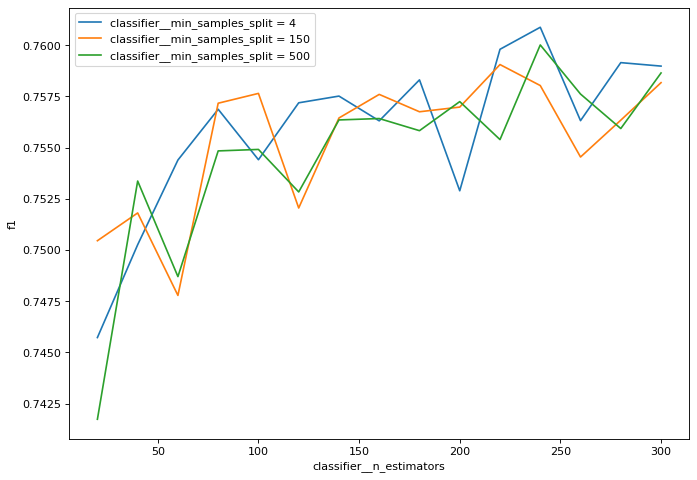

In [ ]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [2],
    'classifier__min_samples_split': [4, 150, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 500, 'classifier__n_estimators': 180}
F1 score : 0.7610060971830158
________________________
CPU times: user 55 s, sys: 13 s, total: 1min 7s
Wall time: 1min 9s


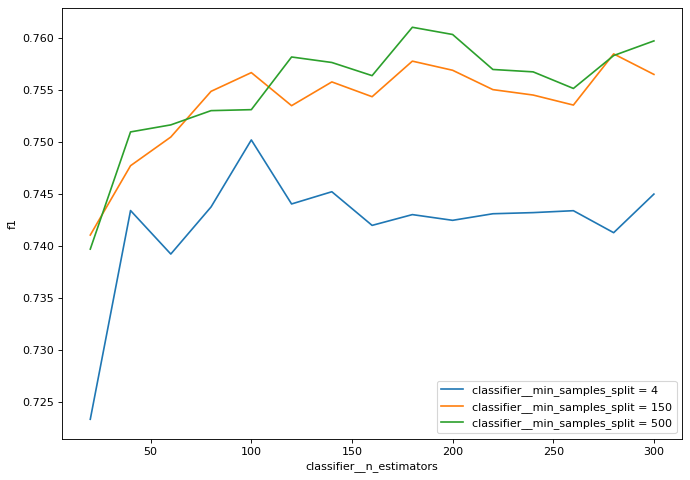

In [433]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1],
    'classifier__min_samples_split': [4, 150, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_transformation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

In [452]:
best_fine_tuning_params[Models.forest_key] =  {
    'classifier__max_depth': 150,
    'classifier__max_features': 'log2',
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 500,
    'classifier__n_estimators': 180
}

### XGBoost

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 200}
F1 score : 0.7559440965026649
________________________
CPU times: user 15min 46s, sys: 3.37 s, total: 15min 49s
Wall time: 3min 43s


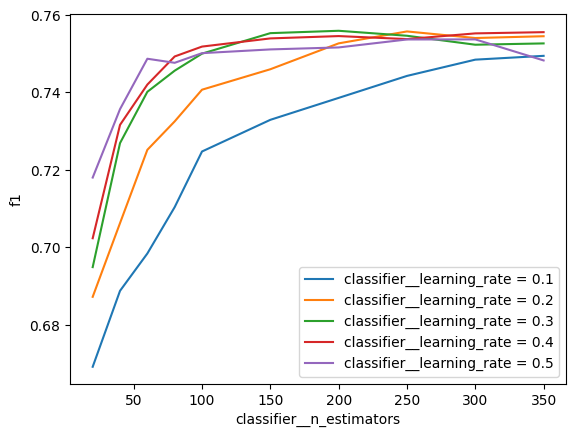

In [350]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__learning_rate')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
F1 score : 0.7591900671569515
________________________
CPU times: user 8min 43s, sys: 2.12 s, total: 8min 45s
Wall time: 2min 47s


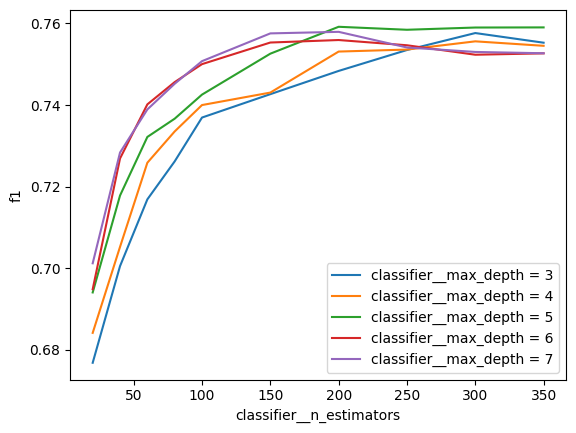

In [385]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [3, 4, 5, 6, 7]
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}
F1 score : 0.7591900671569515
________________________
CPU times: user 21min 17s, sys: 5.82 s, total: 21min 23s
Wall time: 4min 44s


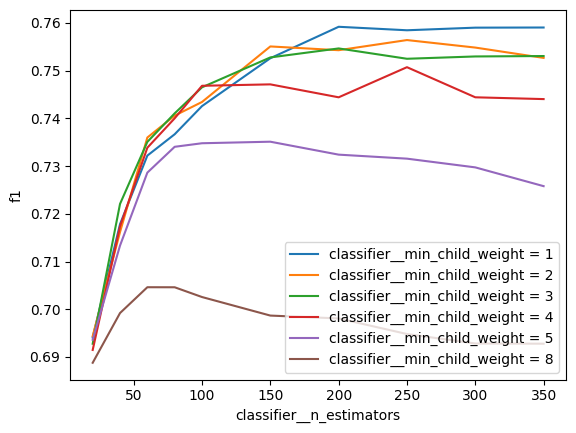

In [389]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [5],
    'classifier__min_child_weight': [1, 2, 3, 4, 5, 8]
}

xgb_tuning_results = grid_search(make_best_transformation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_child_weight')

In [453]:
best_fine_tuning_params[Models.xgb_key] = {
    'classifier__n_estimators': 200,    
    'classifier__learning_rate': 0.3,
    'classifier__max_depth': 5,
    'classifier__min_child_weight': 1
}

### Best fine tuning score

In [455]:
def make_best_fine_tuned_pipeline(key):
    pipeline = make_best_transformation_pipeline(key)

    pipeline.set_params(**(best_fine_tuning_params[key]))
    return pipeline    

In [456]:
best_fine_tuning_pipelines = {
    key: make_best_fine_tuned_pipeline(key) for key in best_fine_tuning_params.keys()
}

In [459]:
%%time
fine_tuning_scores_df = evaluate_pipelines(best_fine_tuning_pipelines, feature_key='Fine tuning')

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

CPU times: user 2min 59s, sys: 3min 14s, total: 6min 13s
Wall time: 1min 6s


In [458]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df, fine_tuning_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.745691,0.722527,0.750751,0.651173,0.704528,0.732792
Default (test),0.742496,0.732157,0.758353,0.655359,0.726650,0.733227
Data preparation (x_val),0.754771,0.725599,0.752912,0.695181,0.727638,0.745573
Data preparation (test),0.748019,0.720623,0.758674,0.702209,0.726821,0.748800
Data transformation (x_val),0.756757,0.750984,0.758621,0.690754,0.732808,0.750037
Data transformation (test),0.741608,0.741259,0.760153,0.696525,0.736053,0.734824
Fine tuning (x_val),0.757841,0.756133,0.761781,0.711517,0.753486,0.759190
Fine tuning (test),0.741259,0.741886,0.755796,0.705185,0.749392,0.753370


In [470]:
%%time
again_df = pd.DataFrame()
for prep_key, prep_params in all_preparation_params.items():
    pipelines = {}
    for key in best_fine_tuning_params.keys():
        print (f'Doing {key}')
        pipeline = make_preparation_pipeline(**prep_params) 
        classifier = make_model(key)
        steps = pipeline.steps.copy()
        steps.append(('poly2_k_best', make_poly2_k_best_pipeline()))
        steps.append(('svd', TruncatedSVD()))
        steps.append(('classifier', classifier))
        pipeline = Pipeline(steps)
        pipeline.set_params(**(best_transformation_params[key]))
        pipeline.set_params(**(best_fine_tuning_params[key]))
        pipelines[key] = pipeline
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        %time again_df = pd.concat((again_df, evaluate_pipelines(pipelines, feature_key=prep_key)))

Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 2s, sys: 1min 57s, total: 4min
Wall time: 42.5 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 17s, sys: 2min, total: 4min 18s
Wall time: 58.6 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 3min 57s, sys: 1min 59s, total: 5min 57s
Wall time: 2min 32s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 7s, sys: 2min 9s, total: 4min 16s
Wall time: 43.8 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 18s, sys: 2min 21s, total: 4min 40s
Wall time: 47.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU 

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1683; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1709; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1716; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1703; got 1750. Use k='all' to return all features.


Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 3min 43s, sys: 2min 2s, total: 5min 45s
Wall time: 2min 30s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 58s, sys: 2min 14s, total: 4min 12s
Wall time: 43.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 22s, sys: 2min 8s, total: 4min 30s
Wall time: 59.5 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 45s, sys: 1min 44s, total: 3min 29s
Wall time: 36.1 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 1min 56s, sys: 2min 3s, total: 3min 59s
Wall time: 41.4 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBo

ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1680; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1707; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1714; got 1750. Use k='all' to return all features.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 422, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/base.py", line 870, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 471, in fit
    self._check_params(X, y)
  File "/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py", line 668, in _check_params
    raise ValueError(
ValueError: k should be >=0, <= n_features = 1700; got 1750. Use k='all' to return all features.


Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 23s, sys: 2min 13s, total: 4min 36s
Wall time: 1min 3s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 35s, sys: 2min 37s, total: 5min 12s
Wall time: 52.4 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 12s, sys: 2min 20s, total: 4min 32s
Wall time: 47.2 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 39s, sys: 3min, total: 5min 39s
Wall time: 55.9 s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoost
CPU times: user 2min 46s, sys: 2min 41s, total: 5min 28s
Wall time: 1min 9s
Doing Naive Bayes
Doing Ridge Classifier
Doing Logistic Regression
Doing Tree
Doing Forest
Doing XGBoo

In [475]:
again_diffs = again_df - fine_tuning_scores_df.loc['Fine tuning (x_val)']

In [486]:
again_diffs = again_diffs[again_diffs.index.str.contains('val')]

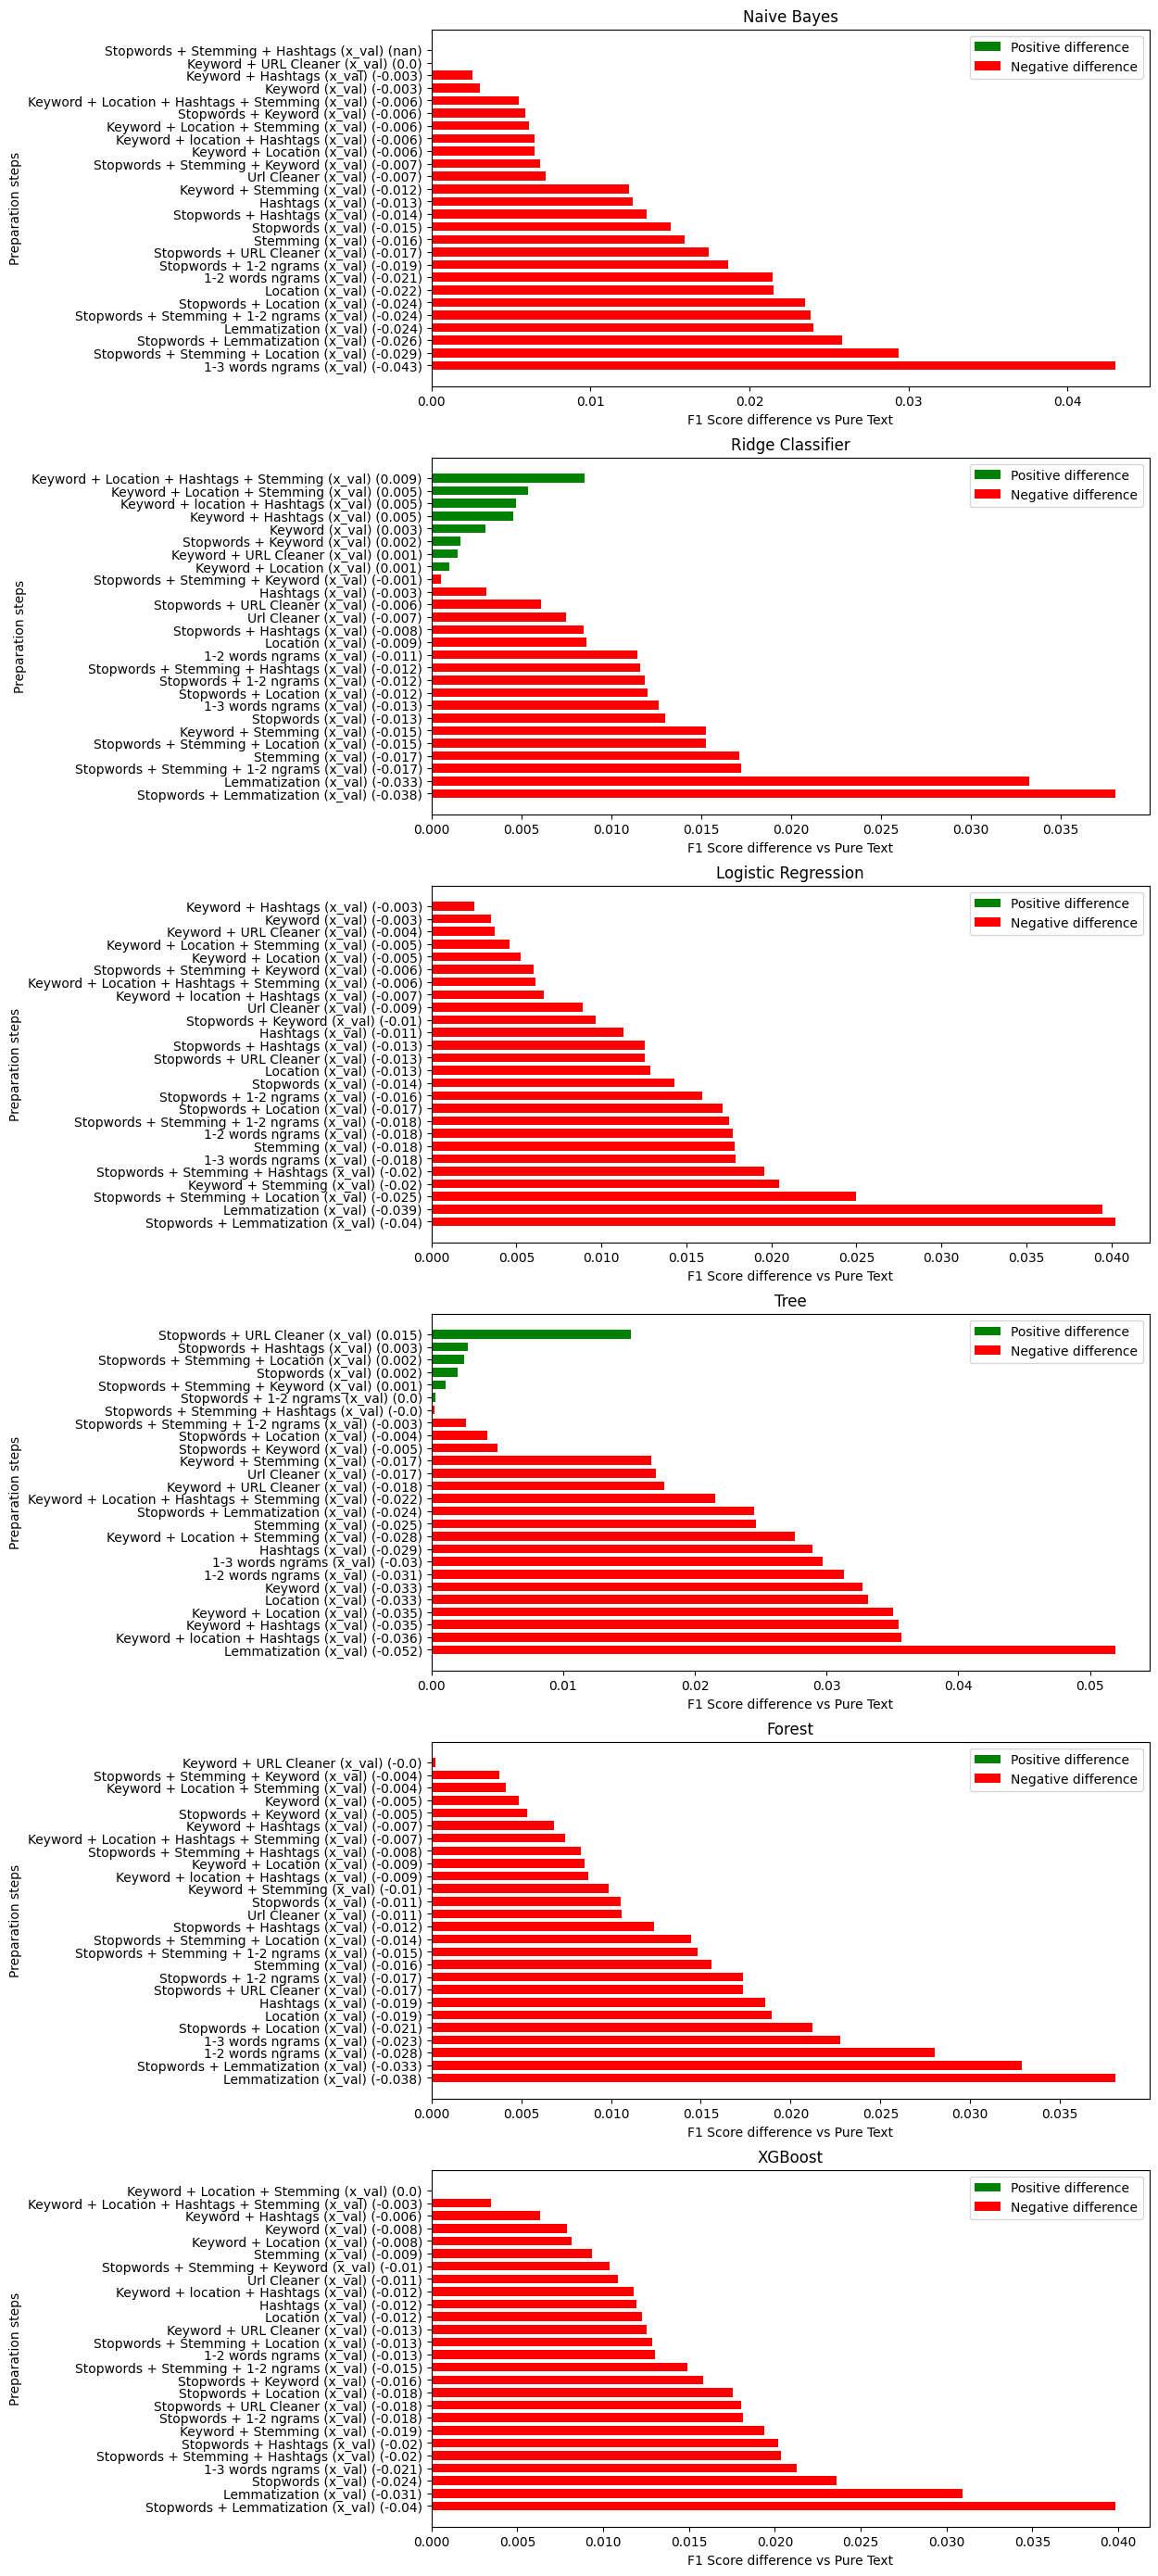

In [487]:
plot_score_diffs(again_diffs)

In [488]:
best_again_params = again_diffs.idxmax()
best_again_params

Naive Bayes                               Keyword + URL Cleaner (x_val)
Ridge Classifier       Keyword + Location + Hashtags + Stemming (x_val)
Logistic Regression                          Keyword + Hashtags (x_val)
Tree                                    Stopwords + URL Cleaner (x_val)
Forest                                    Keyword + URL Cleaner (x_val)
XGBoost                           Keyword + Location + Stemming (x_val)
dtype: object

In [ ]:
best_again_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

## Train and test winner models

In [79]:
%%time
train_data_sag = prepare_data_tkl_poly(df_full_train, svd_n_components=1000)
test_data_sag = prepare_test_data_tkl_poly(df_test, train_data_sag)

CPU times: user 1h 23min 39s, sys: 16min 1s, total: 1h 39min 40s
Wall time: 1h 38min 10s


In [80]:
stemmer.stem('blown')

'blown'

In [81]:
%%time
model_lr_sag = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
model_lr_sag.fit(train_data_sag['vectors'], df_full_train.target)
f1_score(df_test.target, model_lr_sag.predict(test_data_sag))

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7613542526837325

In [82]:
%%time
train_data_rc = prepare_data_tkl_poly(df_full_train, svd_n_components=700)
test_data_rc = prepare_test_data_tkl_poly(df_test, train_data_rc)

CPU times: user 2min 44s, sys: 29.8 s, total: 3min 14s
Wall time: 2min 10s


In [83]:
%%time
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_rc.fit(train_data_rc['vectors'], df_full_train.target)
f1_score(df_test.target, model_rc.predict(test_data_rc))

CPU times: user 58.9 ms, sys: 235 ms, total: 294 ms
Wall time: 77.1 ms


0.7491909385113268

Stemmer + stopwords: 0.76, 0.75

Stemmer: 0.76, 0.75

Stopwords: 0.75, 0.74

Plain: 0.74, 0.75

Lemma: 0.75, 0.74

In [85]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model_lr = LogisticRegression(max_iter=500, random_state=42)
grids_lr = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr[scoring] = clf

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8213453718411428
________________________
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
f1 : 0.7749059682772194
________________________
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
roc_auc : 0.880072438164868
________________________
CPU times: user 44min 28s, sys: 6min 32s, total: 51min 1s
Wall time: 38min 41s


In [86]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']
parameters = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4],
    'solver': ['lsqr', 'saga', 'sag'],
}

model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
grids_rc = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_rc,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_rc[scoring] = clf

Tuned Hyperparameters : {'alpha': 0.5, 'solver': 'saga'}
accuracy : 0.8164196943407395
________________________
Tuned Hyperparameters : {'alpha': 2, 'solver': 'sag'}
f1 : 0.7745214652653776
________________________
Tuned Hyperparameters : {'alpha': 4, 'solver': 'saga'}
roc_auc : 0.8777037458819706
________________________
CPU times: user 21min 22s, sys: 1min 20s, total: 22min 43s
Wall time: 20min 5s


In [92]:
pd.DataFrame(grids_rc['accuracy'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.805582,0.009981
1,0.1,saga,0.816255,0.008197
2,0.1,sag,0.814121,0.008179
3,0.5,lsqr,0.805582,0.009981
4,0.5,saga,0.816420,0.008249
5,0.5,sag,0.814121,0.008179
6,1,lsqr,0.806074,0.009921
7,1,saga,0.816255,0.008197
8,1,sag,0.814121,0.008179
9,2,lsqr,0.806731,0.008809


In [93]:
pd.DataFrame(grids_rc['f1'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.764547,0.015062
1,0.1,saga,0.773567,0.012115
2,0.1,sag,0.772884,0.012035
3,0.5,lsqr,0.764547,0.015062
4,0.5,saga,0.773725,0.012135
5,0.5,sag,0.772884,0.012035
6,1,lsqr,0.764989,0.015170
7,1,saga,0.773475,0.012106
8,1,sag,0.772794,0.012061
9,2,lsqr,0.765753,0.014674


In [94]:
pd.DataFrame(grids_rc['roc_auc'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.867089,0.013634
1,0.1,saga,0.877488,0.011419
2,0.1,sag,0.875830,0.012074
3,0.5,lsqr,0.867272,0.013593
4,0.5,saga,0.877515,0.011381
5,0.5,sag,0.875883,0.012060
6,1,lsqr,0.867473,0.013526
7,1,saga,0.877542,0.011338
8,1,sag,0.875950,0.012024
9,2,lsqr,0.867985,0.013486


In [1]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

model_lr_big = LogisticRegression(max_iter=1000, random_state=42)
grids_lr_big = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_sag['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr_big[scoring] = clf

NameError: name 'LogisticRegression' is not defined

In [96]:
current_time = datetime.now().strftime("%H:%M:%S")
print("Time finished =", current_time)

Time finished = 18:58:05
